# Chapter 4. Linear Models

In [1]:
import pandas as pd
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

from rethinking import MAP, coef, extract_samples, link, precis, sim, vcov

In [2]:
sns.set(font_scale=1.25, rc={"figure.figsize": (8, 6)})

pyro.enable_validation()
pyro.set_rng_seed(1)

### Code 4.1

In [3]:
pos = torch.empty(1000, 16).uniform_(-1, 1).sum(1)

### Code 4.2

In [4]:
(1 + torch.empty(12).uniform_(0, 0.1)).prod()

tensor(1.5286)

### Code 4.3

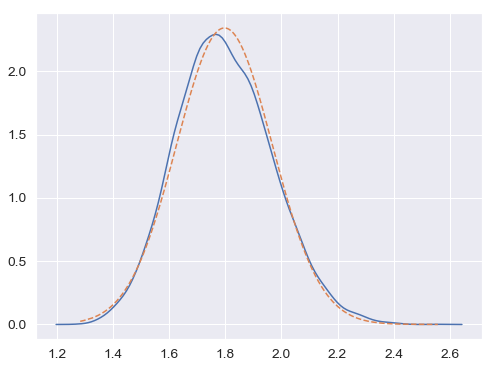

In [5]:
growth = (1 + torch.empty(10000, 12).uniform_(0, 0.1)).prod(1)
sns.distplot(growth, hist=False)
ax = sns.lineplot(growth, dist.Normal(growth.mean(), growth.std()).log_prob(growth).exp())
ax.lines[1].set_linestyle("--")

### Code 4.4

In [6]:
big = (1 + torch.empty(10000, 12).uniform_(0, 0.5)).prod(1)
small = (1 + torch.empty(10000, 12).uniform_(0, 0.01)).prod(1)

### Code 4.5

In [7]:
log_big = (1 + torch.empty(10000, 12).uniform_(0, 0.5)).prod(1).log()

### Code 4.6

In [8]:
w, n = 6., 9
p_grid = torch.linspace(start=0, end=1, steps=1000)
posterior = (dist.Binomial(n, p_grid).log_prob(torch.tensor(w)).exp()
             * dist.Uniform(0, 1).log_prob(p_grid).exp())
posterior = posterior / posterior.sum()

### Code 4.7

In [9]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1

### Code 4.8

In [10]:
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.9

In [11]:
d["height"].head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

### Code 4.10

In [12]:
d2 = d[d["age"] >= 18]
d2_height = torch.tensor(d2["height"], dtype=torch.float)

### Code 4.11

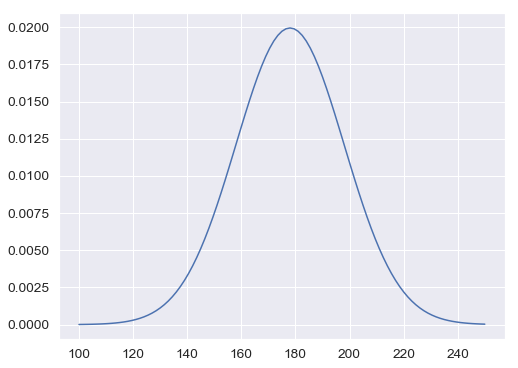

In [13]:
x = torch.linspace(100, 250, 101)
sns.lineplot(x, dist.Normal(178, 20).log_prob(x).exp());

### Code 4.12

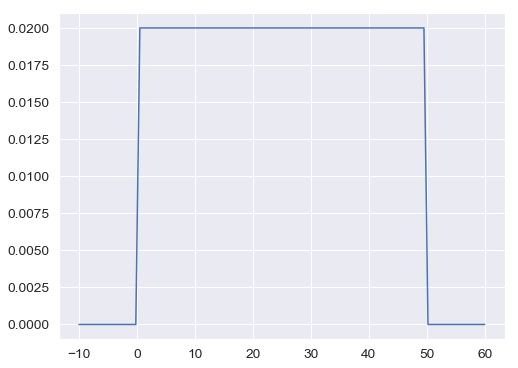

In [14]:
x = torch.linspace(-10, 60, 101)
sns.lineplot(x, dist.Uniform(0, 50, validate_args=False).log_prob(x).exp());

### Code 4.13

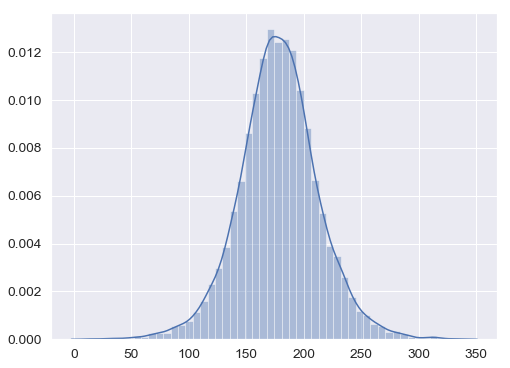

In [15]:
sample_mu = torch.empty(int(1e4)).normal_(178, 20)
sample_sigma = torch.empty(int(1e4)).uniform_(0, 50)
prior_h = dist.Normal(sample_mu, sample_sigma).sample()
sns.distplot(prior_h);

### Code 4.14

In [16]:
mu_list = torch.linspace(start=140, end=160, steps=200)
sigma_list = torch.linspace(start=4, end=9, steps=200)
post = {"mu": mu_list.expand(200, 200).reshape(-1),
        "sigma": sigma_list.expand(200, 200).t().reshape(-1)}
post_LL = dist.Normal(post["mu"], post["sigma"]).log_prob(d2_height.unsqueeze(1)).sum(0)
post_prod = (post_LL + dist.Normal(178, 20).log_prob(post["mu"])
             + dist.Uniform(0, 50).log_prob(post["sigma"]))
post_prob = (post_prod - max(post_prod)).exp()

### Code 4.15

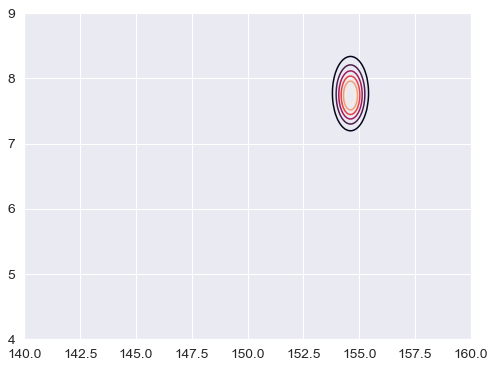

In [17]:
_, ax = sns.mpl.pyplot.subplots()
ax.contour(post["mu"].reshape(200, 200), post["sigma"].reshape(200, 200),
           post_prob.reshape(200, 200));

### Code 4.16

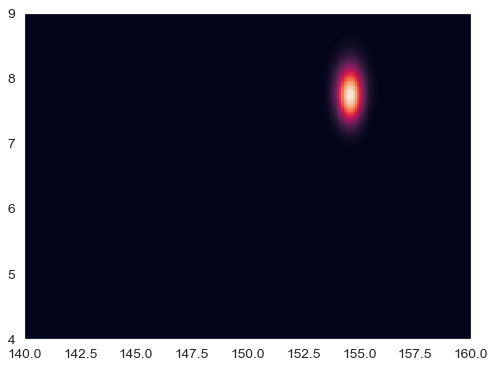

In [18]:
_, ax = sns.mpl.pyplot.subplots()
ax.imshow(post_prob.reshape(200, 200), origin="lower",
          extent=(140, 160, 4, 9), aspect="auto")
ax.grid(False)

### Code 4.17

In [19]:
sample_rows = torch.multinomial(input=post_prob, num_samples=int(1e4), replacement=True)
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

### Code 4.18

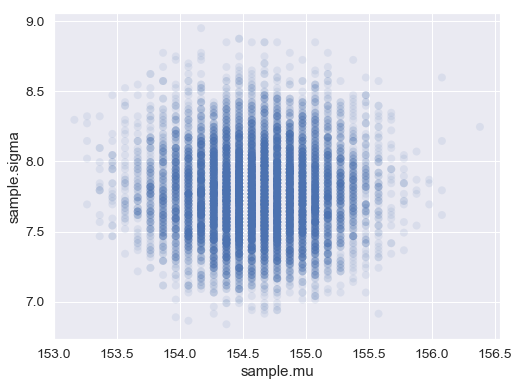

In [20]:
ax = sns.scatterplot(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")
ax.set(xlabel="sample.mu", ylabel="sample.sigma");

### Code 4.19

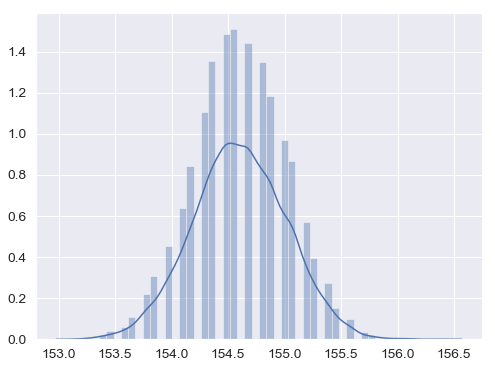

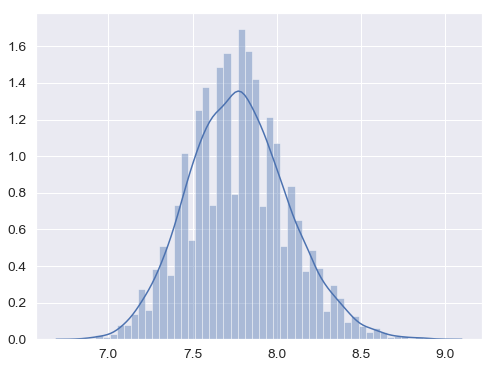

In [21]:
sns.distplot(sample_mu)
sns.mpl.pyplot.show()
sns.distplot(sample_sigma);

### Code 4.20

In [22]:
print(stats.hpdi(sample_mu, 0.89))
print(stats.hpdi(sample_sigma, 0.89))

tensor([153.8694, 155.1759])
tensor([7.3166, 8.2462])


### Code 4.21

In [23]:
d3 = stats.resample(d2_height, num_samples=20)

### Code 4.22

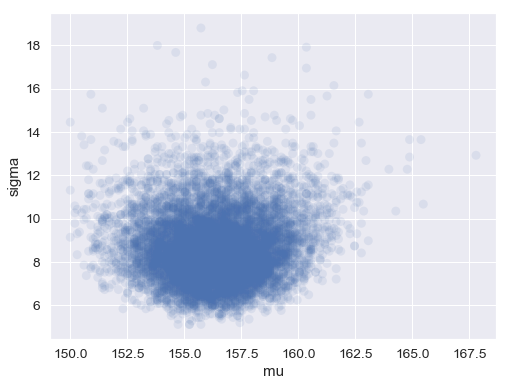

In [24]:
mu_list = torch.linspace(start=150, end=170, steps=200)
sigma_list = torch.linspace(start=4, end=20, steps=200)
post2 = {"mu": mu_list.expand(200, 200).reshape(-1),
         "sigma": sigma_list.expand(200, 200).t().reshape(-1)}
post2_LL = dist.Normal(post2["mu"], post2["sigma"]).log_prob(d3.unsqueeze(1)).sum(0)
post2_prod = (post2_LL + dist.Normal(178, 20).log_prob(post2["mu"])
              + dist.Uniform(0, 50).log_prob(post2["sigma"]))
post2_prob = (post2_prod - max(post2_prod)).exp()
sample2_rows = torch.multinomial(input=post2_prob, num_samples=int(1e4), replacement=True)
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
ax = sns.scatterplot(sample2_mu, sample2_sigma, s=80, alpha=0.1, edgecolor="none")
ax.set(xlabel="mu", ylabel="sigma");

### Code 4.23

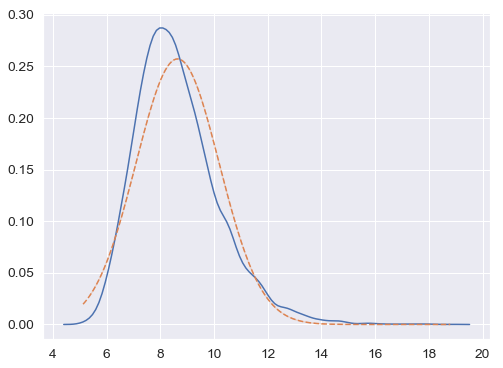

In [25]:
sns.distplot(sample2_sigma, hist=False)
ax = sns.lineplot(sample2_sigma, dist.Normal(sample2_sigma.mean(), sample2_sigma.std())
                  .log_prob(sample2_sigma).exp())
ax.lines[1].set_linestyle("--")

### Code 4.24

In [26]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d2 = d[d["age"] >= 18]

### Code 4.25

In [27]:
def flist(height):
    mu = pyro.sample("mu", dist.Normal(178, 20))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

### Code 4.26

In [28]:
d2_height = torch.tensor(d2["height"], dtype=torch.float)
m4_1 = MAP(flist).run(d2_height)

### Code 4.27

In [29]:
precis(m4_1)

,Mean,StdDev,|0.89,0.89|
mu,154.62,0.41,153.95,155.27
sigma,7.74,0.29,7.29,8.21


### Code 4.28

In [30]:
start = {"mu": d2_height.mean(), "sigma": d2_height.std()}

### Code 4.29

In [31]:
def model(height):
    mu = pyro.sample("mu", dist.Normal(178, 0.1))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_2 = MAP(model).run(d2_height)
precis(m4_2)

,Mean,StdDev,|0.89,0.89|
mu,177.87,0.10,177.71,178.03
sigma,24.53,0.92,23.02,25.98


### Code 4.30

In [32]:
vcov(m4_1)

tensor([[ 0.1708, -0.0003],
        [-0.0003,  0.0845]])

### Code 4.31

In [33]:
print(vcov(m4_1).diag())
cov = vcov(m4_1)
print(cov / cov.diag().ger(cov.diag()).sqrt())

tensor([0.1708, 0.0845])
tensor([[ 1.0000, -0.0025],
        [-0.0025,  1.0000]])


### Code 4.32

In [34]:
post = extract_samples(m4_1)
{latent: post[latent][:5] for latent in post}

{'mu': tensor([154.5516, 154.4029, 153.6991, 154.7805, 154.0881]),
 'sigma': tensor([7.9425, 7.5813, 7.5680, 7.9209, 7.8094])}

### Code 4.33

In [35]:
precis(post)

,Mean,StdDev,|0.89,0.89|
mu,154.62,0.41,153.95,155.27
sigma,7.74,0.29,7.29,8.21


### Code 4.34

In [36]:
post = dist.MultivariateNormal(torch.stack(list(coef(m4_1).values())),
                               vcov(m4_1)).sample(torch.Size([int(1e4)]))

### Code 4.35

In [37]:
def model(height):
    mu = pyro.sample("mu", dist.Normal(178, 20))
    log_sigma = pyro.sample("log_sigma", dist.Normal(2, 10))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, log_sigma.exp()), obs=height)

m4_1_logsigma = MAP(model).run(d2_height)

### Code 4.36

In [38]:
post = extract_samples(m4_1_logsigma)
sigma = post["log_sigma"].exp()

### Code 4.37

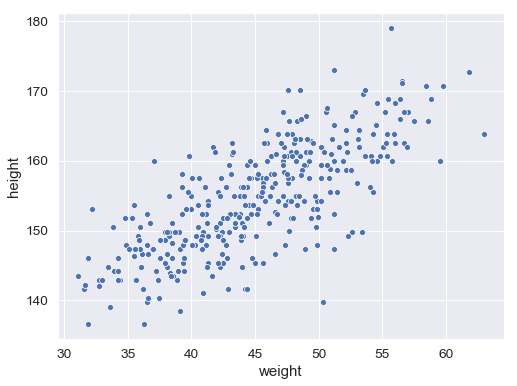

In [39]:
sns.scatterplot("weight", "height", data=d2);

### Code 4.38

In [40]:
# load data again, since it's a long way back
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d2 = d[d["age"] >= 18]

# fit model
def model(weight, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    b = pyro.sample("b", dist.Normal(0, 10))
    mu = a + b * weight
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

d2_weight = torch.tensor(d2["weight"], dtype=torch.float)
d2_height = torch.tensor(d2["height"], dtype=torch.float)
m4_3 = MAP(model).run(d2_weight, d2_height)

### Code 4.39

In [41]:
def model(weight, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    b = pyro.sample("b", dist.Normal(0, 10))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(a + b * weight, sigma), obs=height)

m4_3 = MAP(model).run(d2_weight, d2_height)

### Code 4.40

In [42]:
precis(m4_3)

,Mean,StdDev,|0.89,0.89|
a,113.94,1.90,110.86,116.90
b,0.90,0.04,0.84,0.97
sigma,5.08,0.19,4.77,5.38


### Code 4.41

In [43]:
precis(m4_3, corr=True)

,Mean,StdDev,|0.89,0.89|,a,b,sigma
a,113.94,1.90,110.86,116.90,1.00,-0.99,0.0
b,0.90,0.04,0.84,0.97,-0.99,1.00,-0.0
sigma,5.08,0.19,4.77,5.38,0.00,-0.00,1.0


### Code 4.42

In [44]:
d2_weight_c = d2_weight - d2_weight.mean()

### Code 4.43

In [45]:
m4_4 = MAP(model).run(d2_weight_c, d2_height)

### Code 4.44

In [46]:
precis(m4_4, corr=True)

,Mean,StdDev,|0.89,0.89|,a,b,sigma
a,154.59,0.27,154.19,155.05,1.00,0.02,-0.00
b,0.91,0.04,0.84,0.97,0.02,1.00,0.01
sigma,5.08,0.19,4.77,5.37,-0.00,0.01,1.00


### Code 4.45

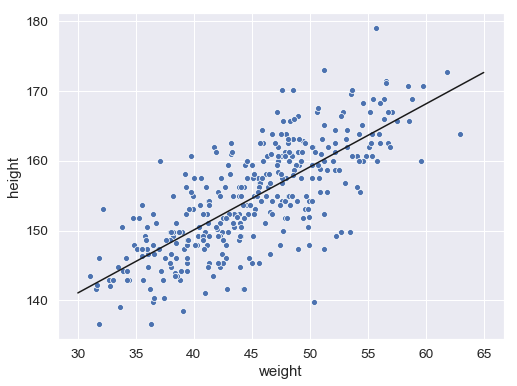

In [47]:
sns.scatterplot("weight", "height", data=d2)
x = torch.linspace(30, 65, 101)
sns.lineplot(x, (coef(m4_3)["a"] + coef(m4_3)["b"] * x), color="k");

### Code 4.46

In [48]:
post = extract_samples(m4_3)

### Code 4.47

In [49]:
{latent: post[latent][:5].detach() for latent in post}

{'a': tensor([114.4491, 115.4891, 111.2624, 112.2713, 113.8299]),
 'b': tensor([0.8990, 0.8758, 0.9592, 0.9381, 0.9119]),
 'sigma': tensor([5.3020, 5.0795, 5.1098, 5.0753, 5.1132])}

### Code 4.48

In [50]:
N = 10
dN = {"weight": d2_weight[:N], "height": d2_height[:N]}
mN = MAP(model).run(**dN)

### Code 4.49

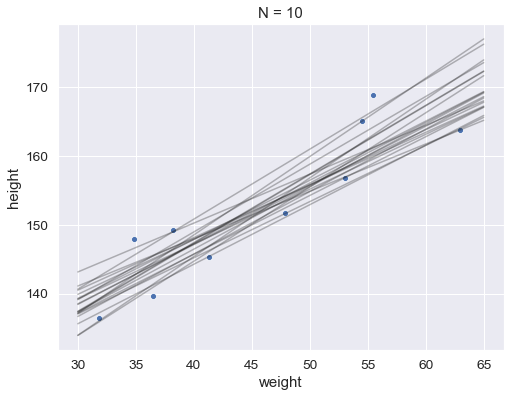

In [51]:
# extract 20 samples from the posterior
idx = mN._categorical.sample(torch.Size([20]))
post = {latent: samples[idx] for latent, samples in extract_samples(mN).items()}

# display raw data and sample size
ax = sns.scatterplot("weight", "height", data=dN)
ax.set(xlabel="weight", ylabel="height", title="N = {}".format(N))

# plot the lines, with transparency
x = torch.linspace(30, 65, 101)
for i in range(20):
    sns.lineplot(x, post["a"][i] + post["b"][i] * x, color="k", alpha=0.3)

### Code 4.50

In [52]:
post = extract_samples(m4_3)
mu_at_50 = post["a"] + post["b"] * 50

### Code 4.51

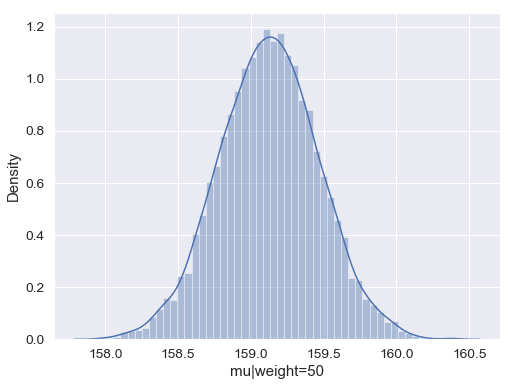

In [53]:
ax = sns.distplot(mu_at_50)
ax.set(xlabel="mu|weight=50", ylabel="Density");

### Code 4.52

In [54]:
stats.hpdi(mu_at_50, prob=0.89)

tensor([158.6010, 159.6755])

### Code 4.53

In [55]:
mu = link(m4_3)
mu.shape, mu[:5, 0]

(torch.Size([1000, 352]),
 tensor([157.0315, 157.3339, 156.7780, 157.2915, 157.2434]))

### Code 4.54

In [56]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = torch.arange(start=25., end=71, step=1)

# use link to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = link(m4_3, data={"weight": weight_seq})
mu.shape, mu[:5, 0]

(torch.Size([1000, 46]),
 tensor([137.3742, 136.4368, 136.2408, 136.1476, 136.5394]))

### Code 4.55

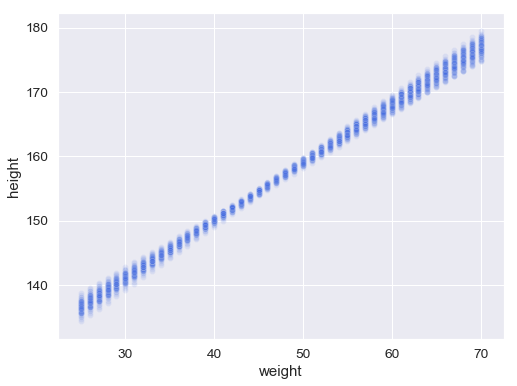

In [57]:
# use visible=False to hide raw data
sns.scatterplot("weight", "height", data=d2, visible=False)

# loop over samples and plot each mu value
for i in range(100):
    sns.scatterplot(weight_seq, mu[i], color="royalblue", alpha=0.1)

### Code 4.56

In [58]:
# summarize the distribution of mu
mu_mean = mu.mean(0)
mu_HPDI = stats.hpdi(mu, prob=0.89, dim=0)

### Code 4.57

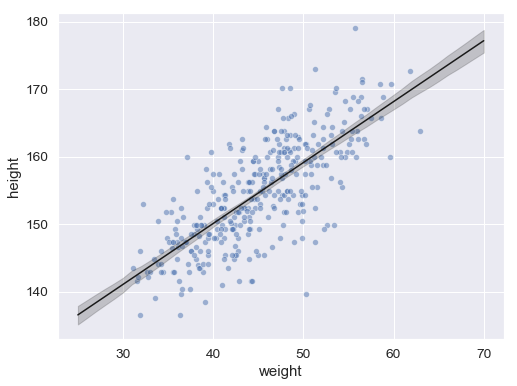

In [59]:
# plot raw data
# fading out points to make line and interval more visible
sns.scatterplot("weight", "height", data=d2, alpha=0.5)

# plot the MAP line, aka the mean mu for each weight
ax = sns.lineplot(weight_seq, mu_mean, color="k")

# plot a shaded region for 89% HPDI
ax.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2);

### Code 4.58

In [60]:
post = extract_samples(m4_3)
mu_link = lambda weight: post["a"].unsqueeze(1) + post["b"].unsqueeze(1) * weight
weight_seq = torch.arange(start=25., end=71, step=1)
mu = mu_link(weight_seq)
mu_mean = mu.mean(0)
mu_HPDI = stats.hpdi(mu, prob=0.89, dim=0)

### Code 4.59

In [61]:
sim_height = sim(m4_3, data={"weight": weight_seq})
sim_height.shape, sim_height[:5, 0]

(torch.Size([1000, 46]),
 tensor([135.7697, 133.4767, 141.8151, 131.0514, 142.0191]))

### Code 4.60

In [62]:
height_PI = stats.pi(sim_height, prob=0.89, dim=0)

### Code 4.61

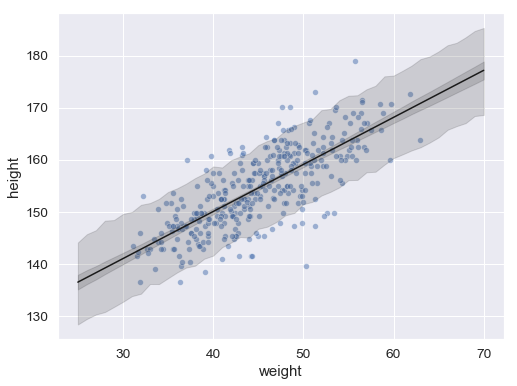

In [63]:
# plot raw data
sns.scatterplot("weight", "height", data=d2, alpha=0.5)

# draw MAP line
ax = sns.lineplot(weight_seq, mu_mean, color="k")

# draw HPDI region for line
ax.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.15)

# draw PI region for simulated heights
ax.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15);

### Code 4.62

In [64]:
sim_height = sim(m4_3, data={"weight": weight_seq}, n=int(1e4))
height_PI = stats.pi(sim_height, prob=0.89, dim=0)

### Code 4.63

In [65]:
def sim_fn(weight):
    mean = post["a"].unsqueeze(1) + post["b"].unsqueeze(1) * weight
    sd = post["sigma"].unsqueeze(1)
    return dist.Normal(loc=mean, scale=sd).sample()

post = extract_samples(m4_3)
weight_seq = torch.arange(start=25., end=71, step=1)
sim_height = sim_fn(weight_seq)
height_PI = stats.pi(sim_height, prob=0.89, dim=0)

### Code 4.64

In [66]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.65

In [67]:
weight = torch.tensor(d["weight"], dtype=torch.float)
weight_s = (weight - weight.mean()) / weight.std()

### Code 4.66

In [68]:
def model(weight, weight2, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    mu = a + b1 * weight + b2 * weight2
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

weight_s2 = weight_s ** 2
height = torch.tensor(d["height"], dtype=torch.float)
m4_5 = MAP(model).run(weight_s, weight_s2, height)

### Code 4.67

In [69]:
precis(m4_5)

,Mean,StdDev,|0.89,0.89|
a,146.65,0.38,146.06,147.25
b1,21.40,0.29,20.95,21.88
b2,-8.41,0.28,-8.87,-7.97
sigma,5.76,0.18,5.48,6.04


### Code 4.68

In [70]:
weight_seq = torch.linspace(start=-2.2, end=2, steps=30)
pred_data = {"weight": weight_seq, "weight2": weight_seq ** 2}
mu = link(m4_5, data=pred_data)
mu_mean = mu.mean(0)
mu_PI = stats.pi(mu, prob=0.89, dim=0)
sim_height = sim(m4_5, data=pred_data)
height_PI = stats.pi(sim_height, prob=0.89, dim=0)

### Code 4.69

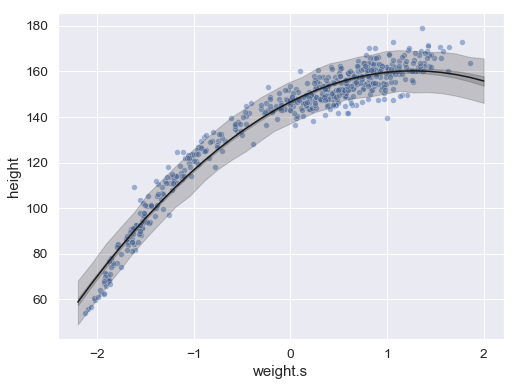

In [71]:
ax = sns.scatterplot(weight_s, height, alpha=0.5)
ax.set(xlabel="weight.s", ylabel="height")
sns.lineplot(weight_seq, mu_mean, color="k")
ax.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
ax.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.2);

### Code 4.70

In [72]:
def model(weight, weight2, weight3, height):
    a = pyro.sample("a", dist.Normal(178, 100))
    b1 = pyro.sample("b1", dist.Normal(0, 10))
    b2 = pyro.sample("b2", dist.Normal(0, 10))
    b3 = pyro.sample("b3", dist.Normal(0, 10))
    mu = a + b1 * weight + b2 * weight2 + b3 * weight3
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(mu, sigma), obs=height)

weight_s3 = weight_s ** 3
m4_6 = MAP(model).run(weight_s, weight_s2, weight_s3, height)

### Code 4.71

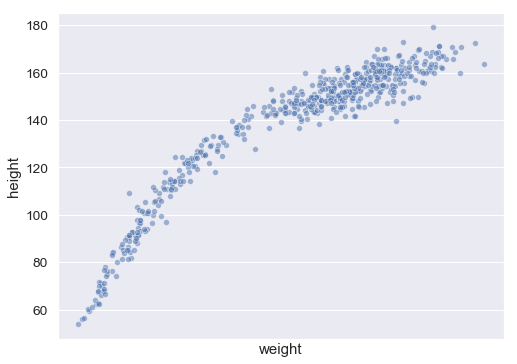

In [73]:
fig, ax = sns.mpl.pyplot.subplots()
sns.scatterplot(weight_s, height, alpha=0.5)
ax.set(xlabel="weight", ylabel="height", xticks=[]);

### Code 4.72

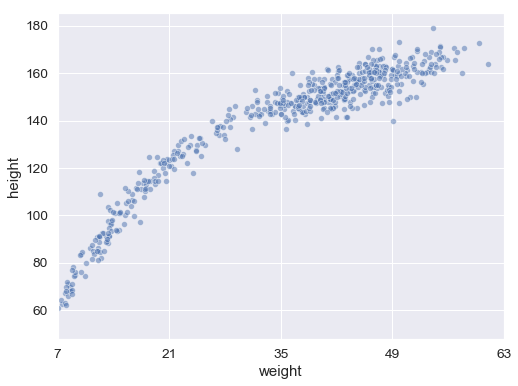

In [74]:
at = torch.tensor([-2, -1, 0, 1, 2])
labels = at * weight.std() + weight.mean()
ax.set_xticks(at)
ax.set_xticklabels([round(label.item(), 1) for label in labels])
fig

### Code 4.73

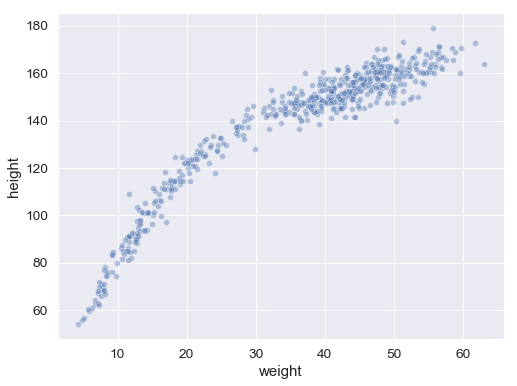

In [75]:
sns.scatterplot("weight", "height", data=howell1, alpha=0.4);